**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

# assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

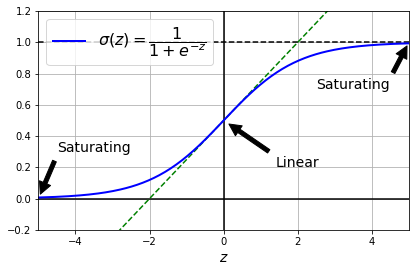

In [5]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leaky ReLU

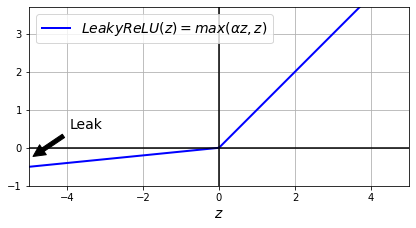

In [8]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

2022-12-04 15:07:54.447887: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [11]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

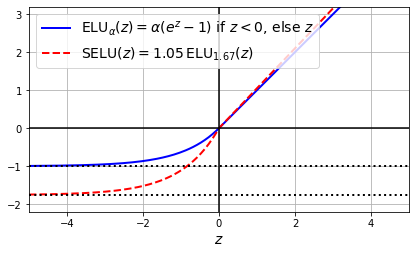

In [12]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [13]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4431872/4422102 [==============================] - 0s 0us/step


In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

2022-12-04 15:08:03.278462: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1719/1719 [==============================] - 68s 37ms/step - loss: 1.2176 - accuracy: 0.5379 - val_loss: 0.8798 - val_accuracy: 0.6896
Epoch 2/5
1719/1719 [==============================] - 59s 34ms/step - loss: 0.8668 - accuracy: 0.6731 - val_loss: 0.7748 - val_accuracy: 0.7156
Epoch 3/5
1719/1719 [==============================] - 60s 35ms/step - loss: 0.6904 - accuracy: 0.7338 - val_loss: 0.6135 - val_accuracy: 0.7652
Epoch 4/5
1719/1719 [==============================] - 60s 35ms/step - loss: 0.6109 - accuracy: 0.7774 - val_loss: 0.5511 - val_accuracy: 0.8040
Epoch 5/5
1719/1719 [==============================] - 58s 34ms/step - loss: 0.5745 - accuracy: 0.7998 - val_loss: 0.5727 - val_accuracy: 0.8006


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 55s 30ms/step - loss: 1.6481 - accuracy: 0.3299 - val_loss: 1.2722 - val_accuracy: 0.4412
Epoch 2/5
1719/1719 [==============================] - 51s 30ms/step - loss: 1.1925 - accuracy: 0.5049 - val_loss: 0.9497 - val_accuracy: 0.6006
Epoch 3/5
1719/1719 [==============================] - 50s 29ms/step - loss: 0.8913 - accuracy: 0.6385 - val_loss: 0.7639 - val_accuracy: 0.7038
Epoch 4/5
1719/1719 [==============================] - 51s 29ms/step - loss: 0.7812 - accuracy: 0.6900 - val_loss: 0.7324 - val_accuracy: 0.7116
Epoch 5/5
1719/1719 [==============================] - 51s 30ms/step - loss: 0.7317 - accuracy: 0.7143 - val_loss: 0.6765 - val_accuracy: 0.7310


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

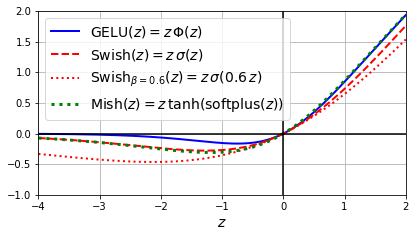

In [24]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In [25]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5558 - accuracy: 0.8095 - val_loss: 0.4013 - val_accuracy: 0.8548
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4082 - accuracy: 0.8562 - val_loss: 0.3683 - val_accuracy: 0.8656


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [30]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 3ms/step - loss: 0.6061 - accuracy: 0.7992 - val_loss: 0.4313 - val_accuracy: 0.8432
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4273 - accuracy: 0.8505 - val_loss: 0.3753 - val_accuracy: 0.8632


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [33]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [34]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [35]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.1385 - accuracy: 0.6260 - val_loss: 0.7101 - val_accuracy: 0.7603
Epoch 2/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.6221 - accuracy: 0.7911 - val_loss: 0.5293 - val_accuracy: 0.8313
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5016 - accuracy: 0.8394 - val_loss: 0.4515 - val_accuracy: 0.8579
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4381 - accuracy: 0.8582 - val_loss: 0.4055 - val_accuracy: 0.8666
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3978 - accuracy: 0.8692 - val_loss: 0.3748 - val_accuracy: 0.8709
Epoch 6/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3693 - accuracy: 0.8782 - val_loss: 0.3538 - val_accuracy: 0.8789
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3487 - accuracy: 0.8825 - val_loss: 0.3376 - val_accuracy:

2022-12-04 15:19:46.516389: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [36]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 48ms/step - loss: 0.7167 - accuracy: 0.5450 - val_loss: 0.7052 - val_accuracy: 0.5272
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6805 - accuracy: 0.5800 - val_loss: 0.6758 - val_accuracy: 0.6004
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6532 - accuracy: 0.6650 - val_loss: 0.6530 - val_accuracy: 0.6746
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6289 - accuracy: 0.7150 - val_loss: 0.6317 - val_accuracy: 0.7517
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6079 - accuracy: 0.7800 - val_loss: 0.6105 - val_accuracy: 0.8091
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5866 - accuracy: 0.8400 - val_loss: 0.5913 - val_accuracy: 0.8447
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5670 - accuracy: 0.8850 - val_loss: 0.5728 - val_accuracy: 0.8833
Epoch 8/20
7/7 [===========

[0.43168649077415466, 0.9185000061988831]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [37]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [38]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [40]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 87ms/step - loss: 1.7897 - accuracy: 0.5550 - val_loss: 1.3328 - val_accuracy: 0.5084
Epoch 2/4
7/7 [==============================] - 0s 19ms/step - loss: 1.1235 - accuracy: 0.5350 - val_loss: 0.9196 - val_accuracy: 0.4807
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.8830 - accuracy: 0.5000 - val_loss: 0.8259 - val_accuracy: 0.4847
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.8195 - accuracy: 0.5250 - val_loss: 0.7788 - val_accuracy: 0.5005
Epoch 1/16
7/7 [==============================] - 1s 45ms/step - loss: 0.7342 - accuracy: 0.6050 - val_loss: 0.6376 - val_accuracy: 0.6924
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.6058 - accuracy: 0.7600 - val_loss: 0.5289 - val_accuracy: 0.8239
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4998 - accuracy: 0.8350 - val_loss: 0.4749 - val_accuracy: 0.8190
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.2547 - accuracy: 0.9385


[0.25473645329475403, 0.9384999871253967]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [44]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

In [45]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6877 - accuracy: 0.7677 - val_loss: 0.4960 - val_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4618 - accuracy: 0.8380 - val_loss: 0.4404 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4176 - accuracy: 0.8527 - val_loss: 0.4207 - val_accuracy: 0.8540
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3902 - accuracy: 0.8621 - val_loss: 0.3813 - val_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3682 - accuracy: 0.8699 - val_loss: 0.3651 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3552 - accuracy: 0.8731 - val_loss: 0.3640 - val_accuracy: 0.8720
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3384 - accuracy: 0.8776 - val_loss: 0.3617 - val_accuracy:

## Momentum optimization

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [49]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6877 - accuracy: 0.7677 - val_loss: 0.4960 - val_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4618 - accuracy: 0.8380 - val_loss: 0.4404 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4176 - accuracy: 0.8527 - val_loss: 0.4207 - val_accuracy: 0.8540
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3902 - accuracy: 0.8621 - val_loss: 0.3813 - val_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3682 - accuracy: 0.8699 - val_loss: 0.3651 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3552 - accuracy: 0.8731 - val_loss: 0.3640 - val_accuracy: 0.8720
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3384 - accuracy: 0.8776 - val_loss: 0.3617 - val_accuracy:

## Nesterov Accelerated Gradient

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [51]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6777 - accuracy: 0.7711 - val_loss: 0.4796 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4569 - accuracy: 0.8397 - val_loss: 0.4365 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4141 - accuracy: 0.8533 - val_loss: 0.4026 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3883 - accuracy: 0.8632 - val_loss: 0.3785 - val_accuracy: 0.8596
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3666 - accuracy: 0.8701 - val_loss: 0.3694 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3532 - accuracy: 0.8731 - val_loss: 0.3681 - val_accuracy: 0.8680
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3375 - accuracy: 0.8782 - val_loss: 0.3645 - val_accuracy:

## AdaGrad

In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0003 - accuracy: 0.6822 - val_loss: 0.6876 - val_accuracy: 0.7744
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6389 - accuracy: 0.7904 - val_loss: 0.5837 - val_accuracy: 0.8050
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5682 - accuracy: 0.8104 - val_loss: 0.5379 - val_accuracy: 0.8152
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5317 - accuracy: 0.8216 - val_loss: 0.5134 - val_accuracy: 0.8244
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5076 - accuracy: 0.8296 - val_loss: 0.4937 - val_accuracy: 0.8288
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4905 - accuracy: 0.8338 - val_loss: 0.4821 - val_accuracy: 0.8314
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4776 - accuracy: 0.8371 - val_loss: 0.4704 - val_accuracy:

## RMSProp

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5127 - accuracy: 0.8142 - val_loss: 0.4613 - val_accuracy: 0.8210
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3957 - accuracy: 0.8586 - val_loss: 0.5067 - val_accuracy: 0.8186
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3744 - accuracy: 0.8669 - val_loss: 0.3776 - val_accuracy: 0.8730
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3684 - accuracy: 0.8727 - val_loss: 0.3757 - val_accuracy: 0.8788
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3606 - accuracy: 0.8761 - val_loss: 0.3801 - val_accuracy: 0.8728
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3603 - accuracy: 0.8765 - val_loss: 0.4719 - val_accuracy: 0.8538
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3626 - accuracy: 0.8771 - val_loss: 0.4445 - val_accuracy:

## Adam Optimization

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4956 - accuracy: 0.8218 - val_loss: 0.4119 - val_accuracy: 0.8414
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3737 - accuracy: 0.8633 - val_loss: 0.4105 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3387 - accuracy: 0.8746 - val_loss: 0.3598 - val_accuracy: 0.8694
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3135 - accuracy: 0.8837 - val_loss: 0.3498 - val_accuracy: 0.8728
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2960 - accuracy: 0.8890 - val_loss: 0.3387 - val_accuracy: 0.8742
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2820 - accuracy: 0.8928 - val_loss: 0.3302 - val_accuracy: 0.8792
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2717 - accuracy: 0.8978 - val_loss: 0.3324 - val_accuracy:

**Adamax Optimization**

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [59]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5322 - accuracy: 0.8158 - val_loss: 0.4423 - val_accuracy: 0.8314
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3942 - accuracy: 0.8595 - val_loss: 0.3853 - val_accuracy: 0.8554
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3558 - accuracy: 0.8715 - val_loss: 0.3738 - val_accuracy: 0.8646
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3329 - accuracy: 0.8801 - val_loss: 0.3504 - val_accuracy: 0.8714
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3125 - accuracy: 0.8855 - val_loss: 0.3300 - val_accuracy: 0.8778
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2985 - accuracy: 0.8908 - val_loss: 0.3364 - val_accuracy: 0.8768
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2843 - accuracy: 0.8947 - val_loss: 0.3510 - val_accuracy:

**Nadam Optimization**

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4824 - accuracy: 0.8282 - val_loss: 0.3867 - val_accuracy: 0.8542
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3618 - accuracy: 0.8671 - val_loss: 0.3656 - val_accuracy: 0.8656
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3273 - accuracy: 0.8772 - val_loss: 0.3569 - val_accuracy: 0.8736
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3050 - accuracy: 0.8878 - val_loss: 0.3413 - val_accuracy: 0.8746
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2901 - accuracy: 0.8914 - val_loss: 0.3297 - val_accuracy: 0.8778
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2736 - accuracy: 0.8979 - val_loss: 0.3512 - val_accuracy: 0.8786
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2637 - accuracy: 0.9001 - val_loss: 0.3472 - val_accuracy:

**AdamW Optimization**

On Colab or Kaggle, we need to install the TensorFlow-Addons library:

In [62]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [63]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

In [64]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4949 - accuracy: 0.8222 - val_loss: 0.4225 - val_accuracy: 0.8432
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3731 - accuracy: 0.8643 - val_loss: 0.4142 - val_accuracy: 0.8376
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3390 - accuracy: 0.8755 - val_loss: 0.3463 - val_accuracy: 0.8728
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3154 - accuracy: 0.8837 - val_loss: 0.3402 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2985 - accuracy: 0.8899 - val_loss: 0.3367 - val_accuracy: 0.8744
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2846 - accuracy: 0.8937 - val_loss: 0.3322 - val_accuracy: 0.8808
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2739 - accuracy: 0.8977 - val_loss: 0.3423 - val_accuracy:

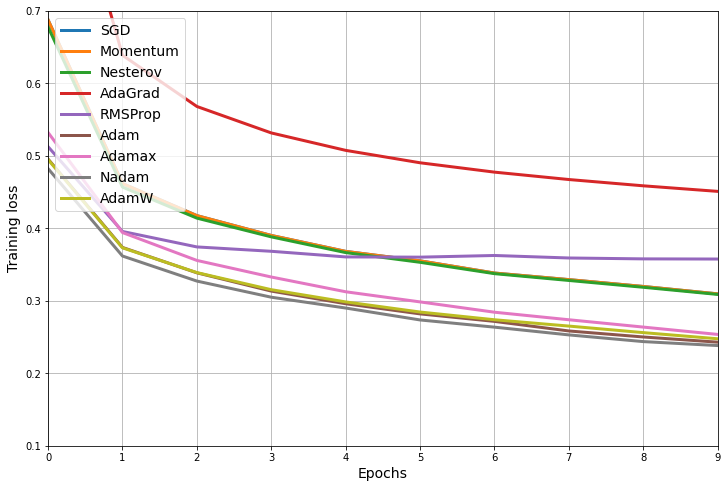

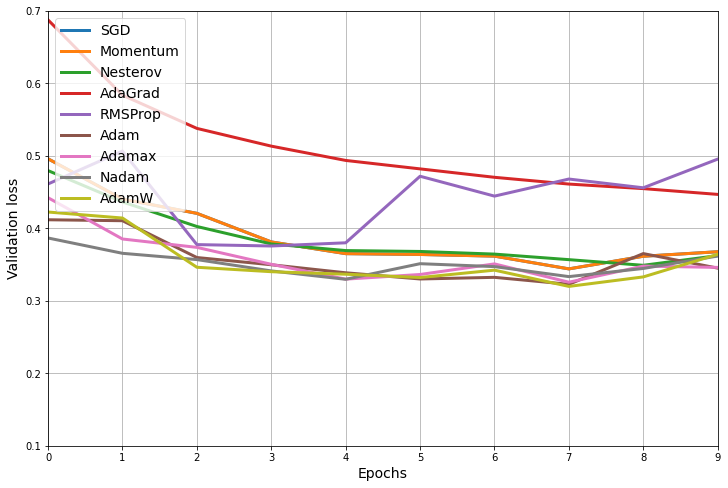

In [65]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [66]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [67]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6818 - accuracy: 0.7679 - val_loss: 0.4838 - val_accuracy: 0.8282
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4699 - accuracy: 0.8359 - val_loss: 0.4431 - val_accuracy: 0.8386
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4243 - accuracy: 0.8490 - val_loss: 0.4117 - val_accuracy: 0.8542
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4012 - accuracy: 0.8580 - val_loss: 0.3898 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3820 - accuracy: 0.8639 - val_loss: 0.3827 - val_accuracy: 0.8614
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3683 - accuracy: 0.8686 - val_loss: 0.3824 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3578 - accuracy: 0.8706 - val_loss: 0.3714 - val_accuracy:

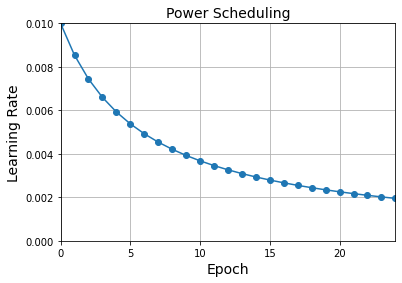

In [68]:
# extra code – this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [69]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [70]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [71]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [72]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6795 - accuracy: 0.7682 - val_loss: 0.4782 - val_accuracy: 0.8314
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4656 - accuracy: 0.8376 - val_loss: 0.4407 - val_accuracy: 0.8404
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4192 - accuracy: 0.8506 - val_loss: 0.4103 - val_accuracy: 0.8534
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3952 - accuracy: 0.8603 - val_loss: 0.3853 - val_accuracy: 0.8608
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3754 - accuracy: 0.8663 - val_loss: 0.3759 - val_accuracy: 0.8628
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3611 - accuracy: 0.8709 - val_loss: 0.3788 - val_accuracy: 0.8646
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3500 - accuracy: 0.8744 - val_loss: 0.3668 - val_accuracy:

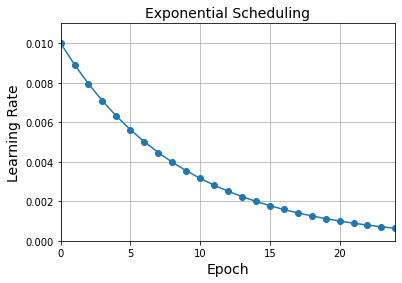

In [73]:
# extra code – this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [74]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [75]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [76]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [77]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6804 - accuracy: 0.7679 - val_loss: 0.4808 - val_accuracy: 0.8284
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4686 - accuracy: 0.8361 - val_loss: 0.4414 - val_accuracy: 0.8408
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4219 - accuracy: 0.8486 - val_loss: 0.4128 - val_accuracy: 0.8536
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3973 - accuracy: 0.8592 - val_loss: 0.3857 - val_accuracy: 0.8582
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3771 - accuracy: 0.8656 - val_loss: 0.3787 - val_accuracy: 0.8630
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3628 - accuracy: 0.8714 - val_loss: 0.3804 - val_accuracy: 0.8604
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3512 - accuracy: 0.8737 - val_loss: 0.3658 - val_accuracy:

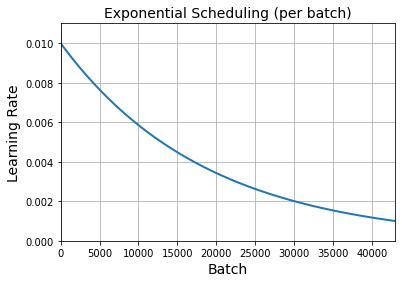

In [78]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [79]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [80]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [81]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5624 - accuracy: 0.8011 - val_loss: 0.4980 - val_accuracy: 0.8072
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4424 - accuracy: 0.8421 - val_loss: 0.4530 - val_accuracy: 0.8392
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4194 - accuracy: 0.8508 - val_loss: 0.4390 - val_accuracy: 0.8446
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4122 - accuracy: 0.8537 - val_loss: 0.4886 - val_accuracy: 0.8420
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3995 - accuracy: 0.8591 - val_loss: 0.4383 - val_accuracy: 0.8454
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3535 - accuracy: 0.8723 - val_loss: 0.3893 - val_accuracy: 0.8614
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3436 - accuracy: 0.8754 - val_loss: 0.3901 - val_accuracy:

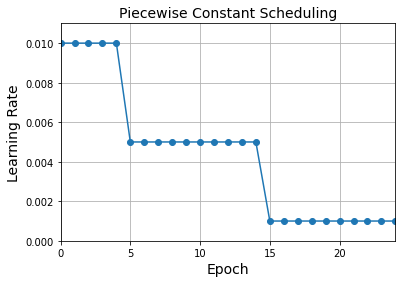

In [82]:
# extra code – this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [83]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [84]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6795 - accuracy: 0.7682 - val_loss: 0.4782 - val_accuracy: 0.8314
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4670 - accuracy: 0.8368 - val_loss: 0.4436 - val_accuracy: 0.8394
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4191 - accuracy: 0.8503 - val_loss: 0.4137 - val_accuracy: 0.8526
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3932 - accuracy: 0.8601 - val_loss: 0.3806 - val_accuracy: 0.8606
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3710 - accuracy: 0.8673 - val_loss: 0.3674 - val_accuracy: 0.8660
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3543 - accuracy: 0.8729 - val_loss: 0.3741 - val_accuracy: 0.8674
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3416 - accuracy: 0.8757 - val_loss: 0.3574 - val_accuracy:

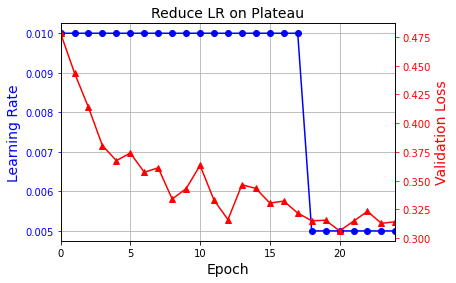

In [85]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [86]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [87]:
# extra code – build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6808 - accuracy: 0.7680 - val_loss: 0.4821 - val_accuracy: 0.8278
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4685 - accuracy: 0.8364 - val_loss: 0.4426 - val_accuracy: 0.8398
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4215 - accuracy: 0.8497 - val_loss: 0.4114 - val_accuracy: 0.8530
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3972 - accuracy: 0.8592 - val_loss: 0.3854 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3771 - accuracy: 0.8657 - val_loss: 0.3777 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3626 - accuracy: 0.8706 - val_loss: 0.3779 - val_accuracy: 0.8614
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3514 - accuracy: 0.8735 - val_loss: 0.3660 - val_accuracy:

For piecewise constant scheduling, try this:

In [88]:
# extra code – shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [89]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [90]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [91]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [92]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 4ms/step - loss: 1.8474 - accuracy: 0.4091


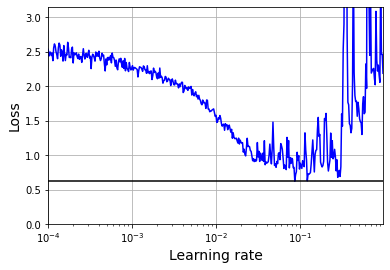

In [93]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [94]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [95]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.9502 - accuracy: 0.6913 - val_loss: 0.6003 - val_accuracy: 0.7874
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5695 - accuracy: 0.8025 - val_loss: 0.4918 - val_accuracy: 0.8248
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4955 - accuracy: 0.8252 - val_loss: 0.4708 - val_accuracy: 0.8282
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4512 - accuracy: 0.8399 - val_loss: 0.4261 - val_accuracy: 0.8478
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4225 - accuracy: 0.8491 - val_loss: 0.4046 - val_accuracy: 0.8506
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3960 - accuracy: 0.8566 - val_loss: 0.4843 - val_accuracy: 0.8192
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3788 - accuracy: 0.8627 - val_loss: 0.3865 - val_accuracy: 0.8602
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [96]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [97]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [98]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [99]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.1224 - accuracy: 0.7748 - val_loss: 1.8602 - val_accuracy: 0.8264
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4263 - accuracy: 0.8158 - val_loss: 1.1269 - val_accuracy: 0.8184


## Dropout

In [100]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [102]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6705 - accuracy: 0.7534 - val_loss: 0.4457 - val_accuracy: 0.8348
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5111 - accuracy: 0.8132 - val_loss: 0.4280 - val_accuracy: 0.8350
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4713 - accuracy: 0.8273 - val_loss: 0.3805 - val_accuracy: 0.8574
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4498 - accuracy: 0.8327 - val_loss: 0.3763 - val_accuracy: 0.8588
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4349 - accuracy: 0.8400 - val_loss: 0.3710 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4231 - accuracy: 0.8433 - val_loss: 0.3686 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4130 - accuracy: 0.8464 - val_loss: 0.3554 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [103]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3092 - accuracy: 0.8838


[0.30921804904937744, 0.8838363885879517]

In [104]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3630 - accuracy: 0.8705


[0.3629508912563324, 0.8705000281333923]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [105]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [106]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [107]:
model.predict(X_test[:1]).round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.053, 0.   , 0.174, 0.   ,
        0.773]], dtype=float32)

In [108]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.118, 0.   , 0.252, 0.   ,
       0.629], dtype=float32)

In [109]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.136, 0.   , 0.197, 0.002,
       0.224], dtype=float32)

In [110]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.87

In [111]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [112]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [113]:
mc_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_dropout (MCDropout)       (None, 784)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               78500     
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 100)               10100     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 100)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 10)              

Now we can use the model with MC Dropout:

In [114]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.21, 0.  , 0.66]],
      dtype=float32)

## Max norm

In [115]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [116]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5502 - accuracy: 0.8025 - val_loss: 0.4614 - val_accuracy: 0.8210
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4082 - accuracy: 0.8505 - val_loss: 0.3920 - val_accuracy: 0.8508
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3777 - accuracy: 0.8602 - val_loss: 0.3916 - val_accuracy: 0.8584
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3569 - accuracy: 0.8692 - val_loss: 0.3516 - val_accuracy: 0.8694
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3441 - accuracy: 0.8729 - val_loss: 0.3490 - val_accuracy: 0.8666
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3379 - accuracy: 0.8747 - val_loss: 0.3724 - val_accuracy: 0.8644
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3278 - accuracy: 0.8759 - val_loss: 0.4037 - val_accuracy:

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [117]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [118]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [119]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [120]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170508288/170498071 [==============================] - 11s 0us/step


Now we can create the callbacks we need and train the model:

In [121]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

2022-12-04 15:52:36.713174: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 15:52:36.713938: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 15:52:36.714970: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [122]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [123]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
   3/1407 [..............................] - ETA: 3:04 - loss: 119.1405 - accuracy: 0.1042

2022-12-04 15:52:57.884253: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 15:52:57.884461: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 15:52:57.905404: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 15:52:57.919983: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 15:52:57.947535: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_001/train/plugins/profile/2022_12_04_15_52_57

2022-12-04 15:52:57.955501: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_cifar10_logs/run_001/train/plugins/profile/2022_12_04_15_52_57/a99fb9597516.trace.json.gz
2022-12-04 15:52:58.001041: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_001/train/plugins/p

1407/1407 [==============================] - 29s 17ms/step - loss: 3.9770 - accuracy: 0.1589 - val_loss: 2.1294 - val_accuracy: 0.2176
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 2.0659 - accuracy: 0.2342 - val_loss: 2.1051 - val_accuracy: 0.2206
Epoch 3/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.9469 - accuracy: 0.2870 - val_loss: 1.9443 - val_accuracy: 0.2910
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.8658 - accuracy: 0.3223 - val_loss: 1.9538 - val_accuracy: 0.3168
Epoch 5/100
1407/1407 [==============================] - 23s 17ms/step - loss: 1.8037 - accuracy: 0.3487 - val_loss: 1.8260 - val_accuracy: 0.3360
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7499 - accuracy: 0.3692 - val_loss: 1.7528 - val_accuracy: 0.3628
Epoch 7/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.7051 - accuracy: 0.3838 - val_loss: 1.6970 - val_

In [124]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 5ms/step - loss: 1.4894 - accuracy: 0.4782


[1.4893600940704346, 0.4781999886035919]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [125]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

2022-12-04 16:16:45.631462: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:16:45.631527: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 16:16:45.631756: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
   2/1407 [..............................] - ETA: 7:40 - loss: 2.4328 - accuracy: 0.0938   

2022-12-04 16:16:59.677541: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:16:59.677733: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 16:17:00.291851: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 16:17:00.330891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 16:17:00.375762: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_bn_001/train/plugins/profile/2022_12_04_16_17_00

2022-12-04 16:17:00.393838: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_cifar10_logs/run_bn_001/train/plugins/profile/2022_12_04_16_17_00/a99fb9597516.trace.json.gz
2022-12-04 16:17:00.473070: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_bn_001/train/

1407/1407 [==============================] - 48s 25ms/step - loss: 2.0694 - accuracy: 0.2345 - val_loss: 1.9077 - val_accuracy: 0.3002
Epoch 2/100
1407/1407 [==============================] - 33s 24ms/step - loss: 1.8044 - accuracy: 0.3476 - val_loss: 2.0019 - val_accuracy: 0.2950
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.6953 - accuracy: 0.3927 - val_loss: 1.8206 - val_accuracy: 0.3532
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.6262 - accuracy: 0.4207 - val_loss: 1.6756 - val_accuracy: 0.4018
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.5627 - accuracy: 0.4469 - val_loss: 1.6751 - val_accuracy: 0.3952
Epoch 6/100
1407/1407 [==============================] - 34s 25ms/step - loss: 1.5128 - accuracy: 0.4634 - val_loss: 1.5920 - val_accuracy: 0.4278
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.4670 - accuracy: 0.4775 - val_loss: 1.5891 - val_

[1.4150547981262207, 0.504800021648407]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [126]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

2022-12-04 16:37:59.109412: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:37:59.109474: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 16:37:59.109677: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
   2/1407 [..............................] - ETA: 2:36 - loss: 3.0440 - accuracy: 0.1094   

2022-12-04 16:38:07.127307: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:38:07.127499: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   7/1407 [..............................] - ETA: 2:06 - loss: 2.7249 - accuracy: 0.1071

2022-12-04 16:38:07.423135: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 16:38:07.437707: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 16:38:07.454157: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_selu_001/train/plugins/profile/2022_12_04_16_38_07

2022-12-04 16:38:07.461481: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_cifar10_logs/run_selu_001/train/plugins/profile/2022_12_04_16_38_07/a99fb9597516.trace.json.gz
2022-12-04 16:38:07.492926: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_selu_001/train/plugins/profile/2022_12_04_16_38_07

2022-12-04 16:38:07.497690: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to my_cifar10_logs/run_selu_001/train/plugi

1407/1407 [==============================] - 27s 16ms/step - loss: 1.9367 - accuracy: 0.3060 - val_loss: 1.8440 - val_accuracy: 0.3280
Epoch 2/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.7090 - accuracy: 0.3916 - val_loss: 1.6973 - val_accuracy: 0.3916
Epoch 3/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6091 - accuracy: 0.4296 - val_loss: 1.6477 - val_accuracy: 0.3992
Epoch 4/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5418 - accuracy: 0.4551 - val_loss: 1.6506 - val_accuracy: 0.4294
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4860 - accuracy: 0.4755 - val_loss: 1.5915 - val_accuracy: 0.4328
Epoch 6/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4394 - accuracy: 0.4970 - val_loss: 1.5220 - val_accuracy: 0.4614
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.3980 - accuracy: 0.5106 - val_loss: 1.4993 - val_

[1.4733667373657227, 0.48840001225471497]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [127]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

2022-12-04 16:49:00.270661: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:49:00.270725: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 16:49:00.270880: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
   2/1407 [..............................] - ETA: 3:14 - loss: 3.1617 - accuracy: 0.0781   

2022-12-04 16:49:09.604744: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 16:49:09.604924: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   7/1407 [..............................] - ETA: 2:25 - loss: 2.9134 - accuracy: 0.0982

2022-12-04 16:49:09.944328: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 16:49:09.961681: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 16:49:09.978253: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_alpha_dropout_001/train/plugins/profile/2022_12_04_16_49_09

2022-12-04 16:49:09.985611: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_cifar10_logs/run_alpha_dropout_001/train/plugins/profile/2022_12_04_16_49_09/a99fb9597516.trace.json.gz
2022-12-04 16:49:10.019277: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_cifar10_logs/run_alpha_dropout_001/train/plugins/profile/2022_12_04_16_49_09

2022-12-04 16:49:10.024110: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to my_cifar10_lo

1407/1407 [==============================] - 29s 18ms/step - loss: 1.8898 - accuracy: 0.3303 - val_loss: 1.7443 - val_accuracy: 0.3814
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.6678 - accuracy: 0.4106 - val_loss: 1.6824 - val_accuracy: 0.4024
Epoch 3/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.5802 - accuracy: 0.4425 - val_loss: 1.6149 - val_accuracy: 0.4376
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5139 - accuracy: 0.4696 - val_loss: 1.5759 - val_accuracy: 0.4472
Epoch 5/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4535 - accuracy: 0.4910 - val_loss: 1.5765 - val_accuracy: 0.4468
Epoch 6/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4046 - accuracy: 0.5111 - val_loss: 1.5741 - val_accuracy: 0.4572
Epoch 7/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.3612 - accuracy: 0.5269 - val_loss: 1.5443 - val_

[1.489389419555664, 0.49959999322891235]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [128]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [129]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [130]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [131]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.498

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [132]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 6s 14ms/step - loss: nan - accuracy: 0.1747


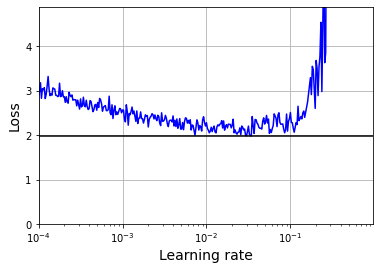

In [133]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [134]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [135]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 7s 16ms/step - loss: 2.0495 - accuracy: 0.2875 - val_loss: 1.7814 - val_accuracy: 0.3806
Epoch 2/15
352/352 [==============================] - 5s 15ms/step - loss: 1.7550 - accuracy: 0.3788 - val_loss: 1.6617 - val_accuracy: 0.4130
Epoch 3/15
352/352 [==============================] - 5s 15ms/step - loss: 1.6213 - accuracy: 0.4256 - val_loss: 1.6484 - val_accuracy: 0.4266
Epoch 4/15
352/352 [==============================] - 5s 16ms/step - loss: 1.5368 - accuracy: 0.4563 - val_loss: 1.6546 - val_accuracy: 0.4210
Epoch 5/15
352/352 [==============================] - 5s 15ms/step - loss: 1.4896 - accuracy: 0.4717 - val_loss: 1.5787 - val_accuracy: 0.4612
Epoch 6/15
352/352 [==============================] - 5s 14ms/step - loss: 1.4483 - accuracy: 0.4852 - val_loss: 1.5522 - val_accuracy: 0.4552
Epoch 7/15
352/352 [==============================] - 5s 15ms/step - loss: 1.4056 - accuracy: 0.5021 - val_loss: 1.5789 - val_accuracy: 0.4530

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).